<a href="https://colab.research.google.com/github/Felixwkk/stocks/blob/master/stocks_lstm_SGX_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Try to use GPU to train the model

!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as spr
import datetime
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8d2416a7852a4dd2191df296cdcddbdacd5bc94af47ec5fbf8dc35babb9afbca
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


Gen RAM Free: 12.6 GB  | Proc size: 500.6 MB
GPU RAM Free: 14968MB | Used: 111MB | Util   1% | Total 15079MB


In [0]:
import os
import random
os.environ['PYTHONHASHSEED'] = '0'

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
# reading SGX data from Yahoo!
stocks = spr.get_data_yahoo('S68.SI', start = datetime.datetime(2011,1,1), end = datetime.datetime(2018, 12, 31))
stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,8.62,8.47,8.49,8.57,2722000.0,5.976152
2011-01-04,8.66,8.60,8.62,8.61,2408000.0,6.004046
2011-01-05,8.63,8.51,8.62,8.53,3878000.0,5.948259
2011-01-06,8.57,8.43,8.54,8.44,7853000.0,5.885501
2011-01-07,8.50,8.43,8.50,8.46,4036000.0,5.899446


In [0]:
stocks.tail()

In [4]:
# retaining only the Open Column
stocks_processed = stocks.iloc[:, 2:3].values
print(len(stocks_processed))
stocks_processed

2006


array([[8.48999977],
       [8.61999989],
       [8.61999989],
       ...,
       [7.11000013],
       [7.17000008],
       [7.1500001 ]])

In [0]:
# normalising the test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

stocks_training_scaled = scaler.fit_transform(stocks_processed)

In [0]:
# based on 60 days past history
days = 60
features_set = []
labels = []
for i in range(days, len(stocks_processed)):
    features_set.append(stocks_training_scaled[i-days:i, 0]) # create 60days of training data into a single cell
    labels.append(stocks_training_scaled[i, 0]) # 61st day stock value into a list

In [7]:
print('length of training data = ',len(stocks_processed),'Features =' ,len(features_set),',Labels =', len(labels))

length of training data =  2006 Features = 1946 ,Labels = 1946


In [0]:
# transforming the data into arrays
features_set, labels = np.array(features_set), np.array(labels)

In [0]:
# creating a 3 dimensional array for LSTM
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))


In [15]:
# prepaing Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras.layers import Bidirectional
#from keras.layers import TimeDistributed
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
#from keras.layers import Flatten
from keras.regularizers import l1_l2
from keras.regularizers import l2,l1
import tensorflow as tf
print(tf.__version__)
model = Sequential()

1.15.0


In [0]:
# Building the LSTM model
model.add(LSTM(units=280, activation = 'relu' ,return_sequences=True, input_shape=(features_set.shape[1], 1)))


In [0]:
model.add(Dropout(0.2))


In [0]:
#model.add(LSTM(units=80, 
               #return_sequences=True,
               #kernel_regularizer=l1_l2(0.0001), 
                #recurrent_regularizer=l2(0.00001), 
                #bias_regularizer=l2(0.000001)
                #))
##model.add(Dropout(0.3))

#model.add(LSTM(units = 80,return_sequences=True,
               #kernel_regularizer=l2(0.0001), 
               #recurrent_regularizer=l2(0.00001), 
               #bias_regularizer=l2(0.000001)
               #))
#model.add(Dropout(0.3))

#model.add(LSTM(units =80,  
                #return_sequences = True,
                #kernel_regularizer=l2(0.000001),
                #recurrent_regularizer=l1_l2(0.00001),
                #bias_regularizer=l1_l2(0.00001)
                #))
#model.add(Dropout(0.2))

model.add(LSTM(units = 300, 
               return_sequences = True,
               recurrent_dropout=.2,
               bias_regularizer=l1(0.00001)
               ))


model.add(LSTM(units = 180, return_sequences = True, recurrent_dropout = .2))
model.add(LSTM(units =120, return_sequences = True, activation='relu'))
model.add(LSTM(units = 100, return_sequences = True,bias_regularizer=l2(0.0001)))
model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(5))
#model.add(LSTM(units=80, 
#               recurrent_regularizer=l2(0.00001)
#               ))
#model.add(Dropout(0.1))

In [0]:

model.add(LSTM(units = 1))

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics= ['accuracy'])


In [21]:
model.fit(features_set, labels, epochs = 20, batch_size = 14, shuffle = True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





1946/1946 [==============================] - 105s 54ms/step - loss: 0.0369 - acc: 5.1387e-04
Epoch 2/20
1946/1946 [==============================] - 93s 48ms/step - loss: 0.0210 - acc: 0.0010
Epoch 3/20
1946/1946 [==============================] - 95s 49ms/step - loss: 0.0179 - acc: 0.0010
Epoch 4/20
1946/1946 [==============================] - 95s 49ms/step - loss: 0.0151 - acc: 0.0010
Epoch 5/20
1946/1946 [==============================] - 95s 49ms/step - loss: 0.0130 - acc: 0.0010
Epoch 6/20
1946/1946 [==============================] - 95s 49ms/step - loss: 0.0108 - acc: 0.0010
Epoch 7/20
1946/1946 [==============================] - 94s 48ms/step - loss: 0.0099 - acc: 0.0010
Epoch 8/20
1946/1946 [==============================] - 93s 48ms/step - loss: 0.0087 - acc: 0.0010
Epoch 9/20
1946/1946 [==============================] - 95s 49ms/step - loss: 0.0083 - acc: 0.0010
Ep

In [0]:
model.save('model_stocks.h5') # saving the model

In [0]:
# this is to load the model from Google
from numpy import loadtxt
from tensorflow.keras.models import load_model

model = load_model('model_stocks.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 60, 80)            26240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 60, 50)            26200     
_________________________________________________________________
lstm_16 (LSTM)               (None, 60, 27)            8424      
_________________________________________________________________
lstm_17 (LSTM)               (None, 9)                 1332      
_________________________________________________________________
dense_4 (De

In [0]:
# getting the validation data set
stocks_test = spr.get_data_yahoo('S68.SI', start = datetime.datetime(2018,12,31), end = datetime.datetime(2019,2,2))

In [24]:
stocks_test

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-31,7.17,7.12,7.17,7.15,497600.0,6.827900
2019-01-01,7.15,7.15,7.15,7.15,0.0,6.827900
2019-01-02,7.23,7.13,7.20,7.17,2110800.0,6.847000
2019-01-03,7.19,7.13,7.16,7.15,1791300.0,6.827900
2019-01-04,7.21,7.12,7.15,7.19,1541500.0,6.866098
2019-01-07,7.27,7.21,7.25,7.26,1777000.0,6.932945
2019-01-08,7.28,7.25,7.28,7.27,1386700.0,6.942494
2019-01-09,7.33,7.28,7.29,7.33,2053400.0,6.999791
2019-01-10,7.35,7.29,7.34,7.33,1621800.0,6.999791


In [0]:
# retain the Open Column
stocks_testing_processed = stocks_test.iloc[:, 2:3].values

stocks_total = pd.concat((stocks['Open'], stocks_test['Open']), axis=0) # combine training and testing data
# test inputs to starts from 60days of test data plus stock test data
test_inputs = stocks_total[len(stocks_total) - len(stocks_test) - 60:].values 

test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [24]:
len(test_inputs)

85

In [25]:
stocks_test.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-31,7.17,7.12,7.17,7.15,497600.0,6.827900
2019-01-01,7.15,7.15,7.15,7.15,0.0,6.827900
2019-01-02,7.23,7.13,7.20,7.17,2110800.0,6.847000
2019-01-03,7.19,7.13,7.16,7.15,1791300.0,6.827900
2019-01-04,7.21,7.12,7.15,7.19,1541500.0,6.866098


In [0]:
len(stocks_total)

2031

In [0]:
# creating the validation data array
test_features = []
for i in range(60, len(test_inputs)):
    test_features.append(test_inputs[i-60:i, 0])

In [0]:
test_features[0]

array([0.46289769, 0.44876326, 0.39929334, 0.3533569 , 0.32508837,
       0.33922264, 0.31802124, 0.33215551, 0.32508837, 0.34628977,
       0.35689055, 0.38869272, 0.38162559, 0.32155489, 0.3533569 ,
       0.3533569 , 0.31448776, 0.29328637, 0.33568916, 0.38515907,
       0.42402838, 0.40989412, 0.45936404, 0.44169612, 0.42402838,
       0.41696125, 0.45229691, 0.44876326, 0.43462899, 0.46643117,
       0.43109551, 0.39929334, 0.43109551, 0.41696125, 0.44169612,
       0.45229691, 0.46289769, 0.46996482, 0.48409908, 0.50176682,
       0.50883396, 0.44169612, 0.46643117, 0.46996482, 0.40636047,
       0.38515907, 0.4134276 , 0.43816264, 0.42049473, 0.44169612,
       0.44522977, 0.4134276 , 0.39929334, 0.39575986, 0.40636047,
       0.37102481, 0.41696125, 0.40989412, 0.43109551, 0.42402838])

In [0]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [0]:
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)

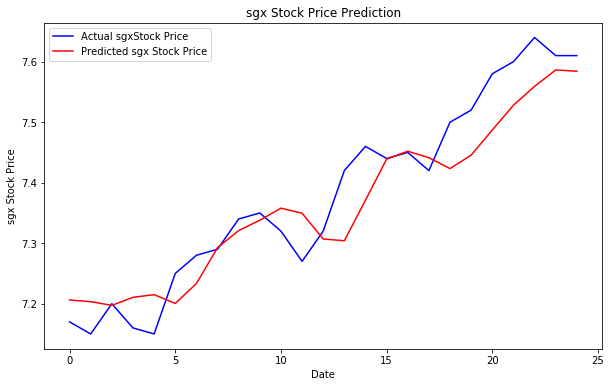

In [29]:
plt.figure(figsize=(10,6))
plt.plot(stocks_testing_processed, color='blue', label='Actual sgxStock Price')
plt.plot(predictions , color='red', label='Predicted sgx Stock Price')
plt.title('sgx Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('sgx Stock Price')
plt.legend()
plt.show()

In [0]:
print(predictions[-1])
print(stocks_test[-1:])

[7.605925]
            High   Low  Open  Close     Volume  Adj Close
Date                                                     
2019-02-01  7.63  7.53  7.61   7.59  2046700.0   7.319843


In [0]:
test_data = spr.get_data_yahoo('S68.SI', start = datetime.datetime(2019,10,15), end = datetime.datetime(2020, 2,4))
test_data = test_data.dropna()
test_data = test_data[-60:]
print(test_data.tail())
test_data = test_data.iloc[:,3:4].values
test = test_data.reshape(-1,1)
test = scaler.transform(test)
input_features = []
input_features.append(test)
test_data[-2:]

            High   Low  Open  Close     Volume  Adj Close
Date                                                     
2020-01-30  8.81  8.69  8.81   8.70  2717900.0      8.625
2020-01-31  8.75  8.60  8.71   8.70  3498200.0      8.700
2020-02-03  8.67  8.57  8.67   8.59  2246300.0      8.590
2020-02-04  8.72  8.60  8.65   8.68  2507600.0      8.680
2020-02-05  8.71  8.61  8.67   8.64  2755700.0      8.640


array([[8.68000031],
       [8.64000034]])

In [0]:
input_pred = np.array(input_features)
#input_features = np.shape(input_features.shape[0]
predict_try = model.predict(input_pred)

In [0]:
predict_try = scaler.inverse_transform(predict_try)


In [0]:
predict_try1 = np.zeros((59,1), dtype=int)
predict_try1 = np.append(predict_try1, predict_try, axis = 0)
predict_try1

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [0]:
predict_try

array([[8.616226]], dtype=float32)

<function matplotlib.pyplot.show>

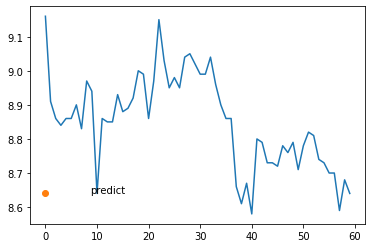

In [0]:
plt.plot(test_data  )
plt.plot(predict_try1[-1],'o')
plt.text(predict_try1[-1], test_data[-1,],'predict')
plt.show

In [0]:
print('last day -' , test_data[-1], 'predict next day -', predict_try)

last day - [8.64000034] predict next day - [[8.640612]]


In [0]:
input_pred

In [0]:
df = spr.get_data_yahoo('S68.SI', start = datetime.datetime(2010,1,1), end = datetime.datetime(2020,1, 16))
df = df.dropna()
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:
train_data = mid_prices[:2100]
test_data = mid_prices[2100:]
print(len(train_data), len(test_data))
df = df.reset_index()

2100 411


In [0]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [0]:
# Train the Scaler with training data and smooth data, window size should be around 4 times of train data
smoothing_window_size = 400
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [0]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00141


In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [0]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00022


In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [0]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.         0.04962308 0.10286792 0.4566449  0.76071805]

	Output: [3.05406888e-06 4.96230796e-02 1.02867916e-01 4.60174352e-01
 7.31030107e-01]


Unrolled index 1
	Inputs:  [1.13427966e-07 4.61587794e-02 1.02096573e-01 4.56965834e-01
 7.55555332e-01]

	Output: [3.0540689e-06 4.2350978e-02 1.0209657e-01 4.6768489e-01 7.4424219e-01]


Unrolled index 2
	Inputs:  [7.7975290e-07 4.3725640e-02 1.0141041e-01 4.6017435e-01 7.4424219e-01]

	Output: [4.6403471e-05 4.2058591e-02 9.9288993e-02 4.8996833e-01 7.4424219e-01]


Unrolled index 3
	Inputs:  [3.0540689e-06 4.2350978e-02 1.0079714e-01 4.6768489e-01 7.3103011e-01]

	Output: [8.9741407e-05 4.2868339e-02 9.9288993e-02 4.9887905e-01 6.9772696e-01]


Unrolled index 4
	Inputs:  [8.9421865e-06 4.2058591e-02 1.0024563e-01 4.7736409e-01 7.1429068e-01]

	Output: [1.6070540e-04 5.2043270e-02 9.9745899e-02 4.8996833e-01 7.1429068e-01]


In [0]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times


In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [0]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 5 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(2100,2500,5).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 10.466220


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.19739
	Finished Predictions
Average loss at step 2: 7.910186
	Test MSE: 0.14819
	Finished Predictions
Average loss at step 3: 5.329999
	Test MSE: 0.09275
	Finished Predictions
Average loss at step 4: 2.510562
	Test MSE: 0.03503
	Finished Predictions
Average loss at step 5: 0.908776
	Test MSE: 0.01660
	Finished Predictions
Average loss at step 6: 1.119552
	Test MSE: 0.01719
	Finished Predictions
Average loss at step 7: 0.655705
	Test MSE: 0.02753
	Finished Predictions
Average loss at step 8: 0.711217
	Decreasing learning rate by 0.5
	Test MSE: 0.02462
	Finished Predictions
Average loss at step 9: 0.626075
	Test MSE: 0.01913
	Finished Predictions
Average loss at step 10: 0.569544
	Test MSE: 0.01692
	Finished Predictions
Average loss at step 11: 0.568327
	Decreasing learning rate by 0.5
	Test MSE: 0.01863
	Finished Predictions
Average loss at step 12: 0.539872
	Test MSE: 0.01951
	Finished Predictions
Average loss at step 13: 0.535145
	Test MSE: 0.01914
	Finished Predictions
A

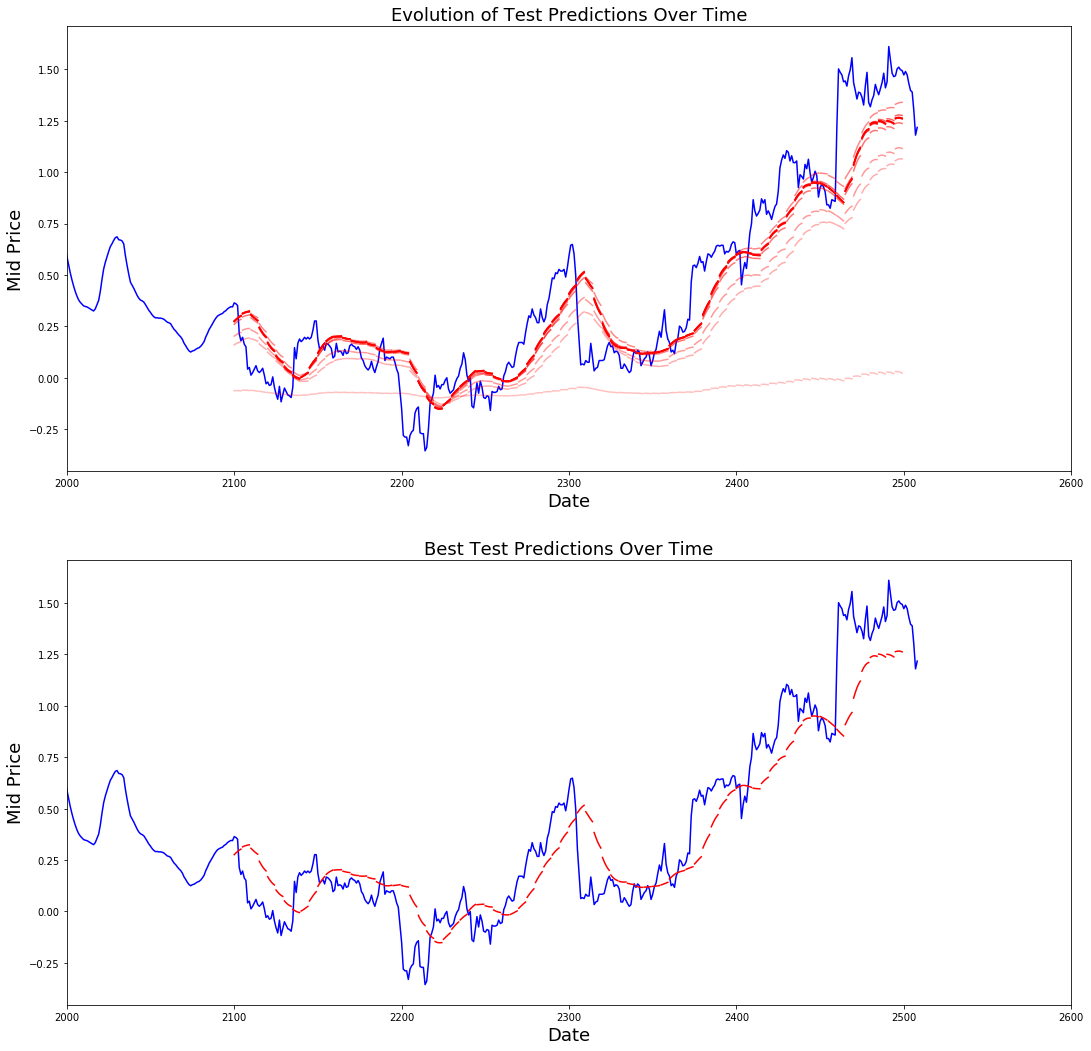

In [0]:
best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(2000,2600)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(2000,2600)
plt.show()

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

In [0]:
#https://mc.ai/how-to-save-and-upload-deep-learning-machine-learning-models-in-google-colab-using-google-drive/
!pip install -U -q PyDrive

import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: output.json, id: 1-25OPsV9jaYFY_WgIbmBYz7nsSI6o_Ib
title: .ipynb_checkpoints, id: 1-0sfZVTwCyD2oB8OHJZTIAVDHP_534ly
title: Untitled, id: 1evf7SG71MW7k5PpAyakjytHv_sK1Ytt3
title: DNU_2006_CD, id: 1pbpullEaEVHFgnEcCo18cErdlZsDcNJm
title: TVBAnywhere+ Intro deck for Partners (MAY2).pdf, id: 1rrpo7rCYLYbaKLPaDKNGQceTjpFMfDHS
title: IMG_1555.JPG, id: 183qNPefv6A4oElqFY32ZQGS3LZfjviqZ
title: Colab Notebooks, id: 1eVPlRqL2oiuPafz7kzb6UDkvlWOVkoVA
title: 190811 OP0801.zip, id: 1BABdUZBPWav2uEnb66GFHY8Gr1ryhSIr
title: Architecture.mp4, id: 1KO-0XAQAPtBu8T3xSURWV5OlWyiLE-oJ
title: G B 006, id: 1gI584C3lzhcjR8f2A4XQVX50tfe8BV4XIQis5SxsxTg
title: bill_authentication.csv, id: 13nw-uRXPY8XIZQxKRNZ3yYlho-CYm_Qt
title: japan.zip, id: 0B_2dy8_ilOY1MHpPX2pyeHZodDA
title: sony ericsson 2.zip, id: 0B_2dy8_ilOY1YWtJWUUxeklPV2M
title: SONY ERICSSON.zip, id: 0B_2dy8_ilOY1Z001VzN2akhxck0
title: field trip 2011.zip, id: 0B_2dy8_ilOY1QjhqOEpCWWF1a1U
title: GOLD COAST.zip, id: 0B_2dy8_ilOY1MmRPakVPT3QzdFk

In [0]:
downloaded = drive.CreateFile({'183qNPefv6A4oElqFY32ZQGS3LZfjviqZ': 'IMG_1555.JPG'})
file = downloaded.GetContentString()
print('Downloaded content "{}"'.format(len(file)))

FileNotUploadedError: ignored

In [0]:
text_file = open("your desired name.txt", "w")
text_file.write(file)    
text_file.close()

In [0]:
uploaded = drive.CreateFile({'title': 'model_stocks.h5'})
uploaded.SetContentFile('model_stocks.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1_EXFhc4qpxae3y7hOKRSx0jDa4FA26J3


In [0]:
from google.colab import files
files.download('model_stocks.h5')